# Worked examples with Ag 1000 Genomes data

### Preamble

In [1]:
library(h5)
library(ggplot2)

In [2]:
sessionInfo()

R version 3.2.2 (2015-08-14)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 14.04.3 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_1.0.1 h5_0.9.6     

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.4          digest_0.6.8         MASS_7.3-44         
 [4] IRdisplay_0.3.0.9000 plyr_1.8.3           repr_0.4            
 [7] grid_3.2.2           jsonlite_0.9.17      gtable_0.1.2        
[10] magrittr_1.5         scales_0.3.0         evaluate_0.8        
[13] stringi_0.5-5        reshape2_1.4.1       uuid_0.1-2     

## Specify filename

In [3]:
fn <- "/home/ag1000g.phase1.ar3.pass.3L.h5"

In [4]:
# create the filehandle to access the data
fh <- h5file(fn, "r")

In [ ]:
list.datasets(fh)

In [5]:
samples <- fh["/3L/samples"]
samples

DataSet 'samples' (765)
type: character
chunksize: NA
maxdim: 765

In [6]:
samples[1:20]

[1] "AB0085-C" "AB0087-C" "AB0088-C" "AB0089-C" "AB0090-C" "AB0091-C"
 [7] "AB0092-C" "AB0094-C" "AB0095-C" "AB0097-C" "AB0098-C" "AB0099-C"
[13] "AB0100-C" "AB0101-C" "AB0103-C" "AB0104-C" "AB0109-C" "AB0110-C"
[19] "AB0111-C" "AB0112-C"

In [7]:
fh["/3L/variants/POS"]

DataSet 'POS' (9.6432e+06)
type: integer
chunksize: 32768
maxdim: UNLIMITED
compression: H5Z_FILTER_DEFLATE

In [12]:
## Function to apply a function f, to values based on windows of positions
# NOTE: The final incomplete window is not included
windowed_analysis <- function(positions, values, f, win_size=100000, ...){

    windows <- seq(0, positions[attr(positions, "dim")], by=100000)
    ix = findInterval(windows, positions[], all.inside=TRUE)
    x = rep(NA, length(windows) - 1)

    for (i in 1:(length(ix)-1)){
        start = ix[i]
        stop  = ix[i + 1]

        v = values[start:stop]
        x[i] = f(v, ...)
    }
    return(list("values"=x, "windows"=windows))
}

In [13]:
get_midpoint <- function(windows){
    
    x = rep(NA, length(windows) - 1)
    
    for (i in 1:length(x)){
        x[i] = mean(c(windows[i], windows[i+1]))
    }
    return(x)
}

## Plot mean mq0 in windows across the genome

In [14]:
mq0_variants <- windowed_analysis(fh["/3L/variants/POS"], 
                                  fh["/3L/variants/CoverageMQ0"], 
                                  mean)

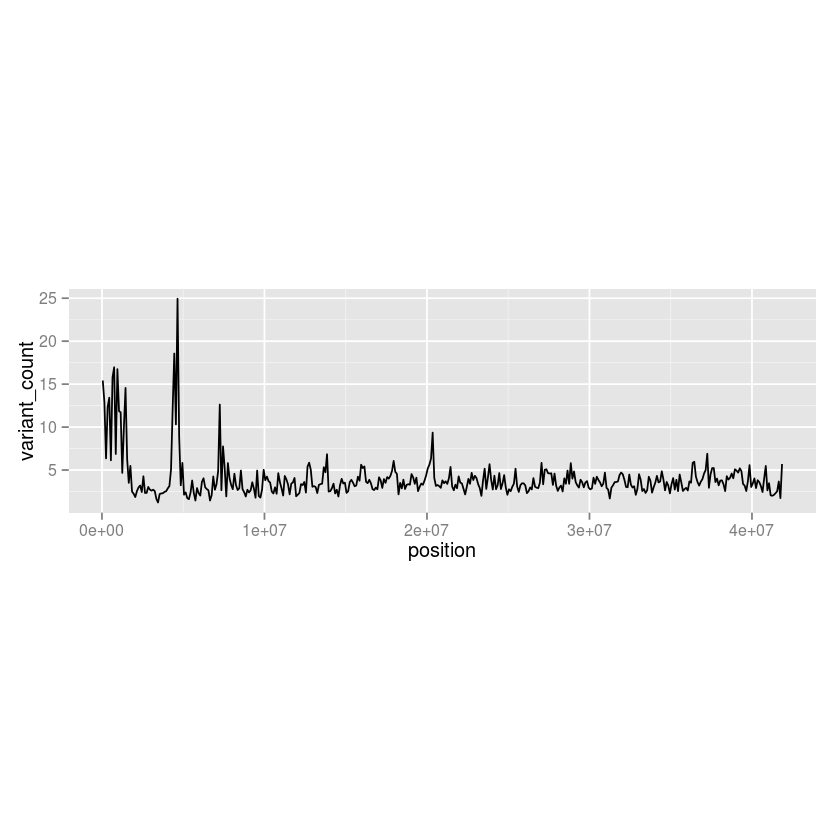

In [15]:
# plot in windows
p <- with(mq0_variants, ggplot(
    data.frame(position=get_midpoint(windows), variant_count=values),
    aes(x=position, y=variant_count)))

p + geom_line() + theme(aspect.ratio=0.3)

## Plot count of variants across the genome

NOTE: Accessibility likely to differ

In [16]:
# as we are just taking the length use pos as the values
count_variants <- windowed_analysis(fh["/3L/variants/POS"], 
                                    fh["/3L/variants/POS"], 
                                    length)

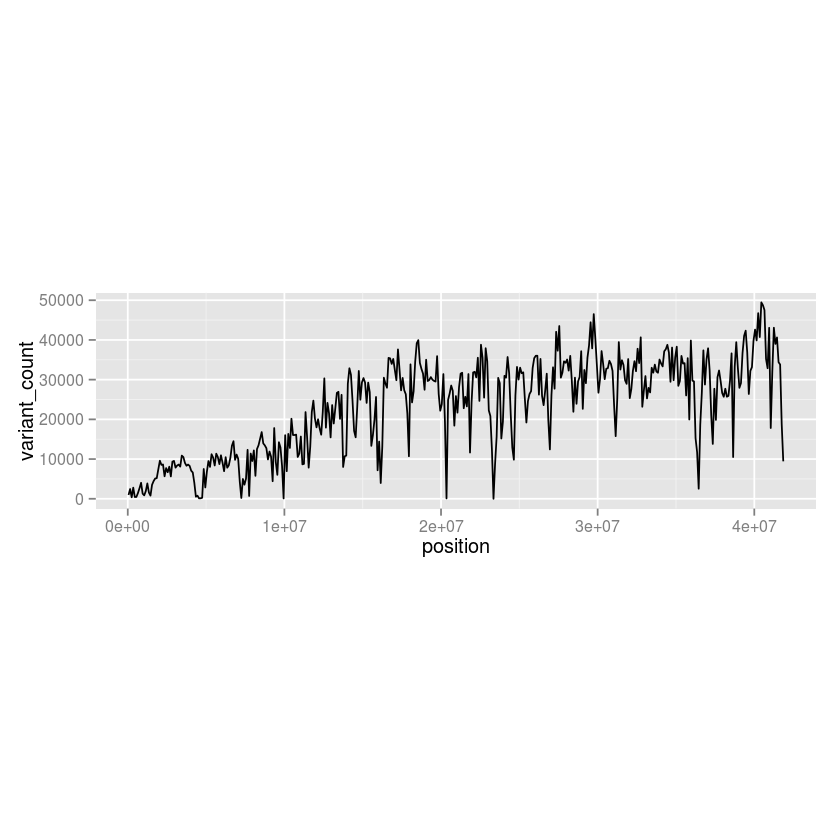

In [17]:
# plot in windows
p <- with(count_variants, ggplot(
    data.frame(position=get_midpoint(windows), variant_count=values),
    aes(x=position, y=variant_count)))

p + geom_line() + theme(aspect.ratio=0.3)

In [82]:
n_snps = 1000

In [162]:
num_alleles = fh["/3L/variants/num_alleles"][1:n_snps]
ok <- num_alleles <= 2

In [163]:
d <- (fh["/3L/calldata/genotype"][which(ok),1:10,1:2])

In [178]:
# trick to recode d to 0/1/2/NA handle missing...
geno <- apply(d, MARGIN=c(1, 2), FUN=sum)
geno[geno < 0] <- NA
storage.mode(geno) <- "integer"

In [179]:
colnames(geno) <- paste0("AG", seq(1, 10, 1))
rownames(geno) <- paste0("p", fh["/3L/variants/POS"][which(ok)])

In [180]:
xx = data.frame(pop=rep(c("POP1", "POP2"), 5), t(geno))

In [181]:
wc(xx)

$FST
[1] 0.02328335

$FIS
[1] -0.4464646


# Calculate Fst between two populations

For this we will need some metadata.

Have to handle the fact that alleles are coded in 1s and 0s.

(Exclude multiallelic variants)

Work out allele freq of non missing alleles in each population. 
Calculate the D, and identify positions where abs(D) > 0.9

In [182]:
install.packages("hierfstat", repos="https://www.stats.bris.ac.uk/R")
library(hierfstat)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



The downloaded source packages are in
	‘/tmp/RtmpjzK0ij/downloaded_packages’


In [183]:
metadata <- read.table("/home/samples.meta.txt",
                       sep="\t", header=TRUE, stringsAsFactors=FALSE, quote="")

In [186]:
head(metadata[,1:5])

,index,ox_code,src_code,sra_sample_accession,population
1,0,AB0085-C,BF2-4,ERS223996,BFS
2,1,AB0087-C,BF3-3,ERS224013,BFM
3,2,AB0088-C,BF3-5,ERS223991,BFM
4,3,AB0089-C,BF3-8,ERS224031,BFM
5,4,AB0090-C,BF3-10,ERS223936,BFM
6,5,AB0091-C,BF3-12,ERS224065,BFM


In [253]:
# calculate windowed fst using weir and cockerham
calculate_windowed_fst <- function(data, popA_ix, popB_ix, window_size=100000, 
                                   start=NULL, stop=NULL){
    
    positions <- data["/3L/variants/POS"]
    
    if (is.null(start)){
        start = 0
    }
    
    if (is.null(stop)){
        stop <- positions[attr(positions, "dim")]
    }
    
    windows <- seq(start, stop, by=window_size)
    ix = findInterval(windows, positions[], all.inside=TRUE)
    fst = rep(NA, length(windows) - 1)
    
    ordering <- order(c(popA_ix, popB_ix))
    indices <- c(popA_ix, popB_ix)[ordering]
    
    populations = c(rep("popA", length(popA_ix)),
                    rep("popB", length(popB_ix)))[ordering]

    for (i in 1:(length(ix)-1)){
        start = ix[i]
        stop  = ix[i + 1]
        
        num_alleles = data["/3L/variants/num_alleles"][start:stop]
        ok <- num_alleles <= 2
                
        # only biallelic
        d <- data["/3L/calldata/genotype"][start:stop, indices, 1:2]
        d <- d[ok,,]
        
        # sum and transpose
        geno <- apply(d, MARGIN=c(1, 2), FUN=sum)
        geno[geno < 0] <- NA
        storage.mode(geno) <- "integer"
        
        colnames(geno) <- paste0("id", seq(1, length(populations), 1))
        rownames(geno) <- paste0("p", positions[start:stop][which(ok)])
        
        xx = data.frame(pop=populations, t(geno))
        fst[i] = wc(xx)$FST
    }
    
    return (data.frame("Fst"=fst,
                       "start"=windows[1:length(windows) -1],
                       "stop"=windows[2:length(windows)]))
}

In [247]:
bfs_ix = which(metadata$population == "BFS")
bfm_ix = which(metadata$population == "BFM")

In [ ]:
# slow...so only compute 5/292 windows.
result = calculate_windowed_fst(fh, gas_ix, aom_ix, start=10000000, stop=10500000)

In [ ]:
result

# Plot hz in a KES sample vs CMS sample

In [ ]:
wc(xx)